# Topic + Sentiment

In [3]:
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from datetime import datetime
import os
import sys
import csv
import re
import stanza
import pandas as pd
import numpy as np
import plotly

# Basic paths
src_path = str(Path.cwd().parent / "pdfs")
sys.path.append(src_path)
src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)

project_path = Path().resolve().parent
csv_path = project_path / "speeches_csv"
sa_path = project_path / "sentiment_analysis" #changed name

## Data Frame Joining

In [9]:
df1 = pd.read_csv(sa_path / "results_sa_all.txt", infer_datetime_format = True, parse_dates = ["date"]) # Update the file!! 
# Use the updated file that has highest_..count <=3
df2 = pd.read_csv(sa_path / "topic_lda.csv")

df2.head()


,title,pages,date,location,highest_speaker_count,content,country,count_commas,state,city,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
0,CGI_2013,19,2013-09-24,"Sheraton New York Hotel and Towers, New York, ...",10,Hillary Clinton: Thank you very much. I have t...,USA,2,New York,New York,...,Topic 2,0.004650,Topic 6,0.004650,Topic 8,0.004650,Topic 3,0.004650,Topic 9,0.004650
1,Prayer_Breakfast_2016,7,2016-02-04,"Washington Hilton, Washington D.C.",0,"Well, good morning. Giving all praise and hono...",USA,1,no_state,Washington D.C.,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
2,Security_Team_Announcement,5,2008-12-01,"Chicago, Illinois",0,"Good morning, everybody. I hope you all had a ...",USA,1,Illinois,Chicago,...,Topic 6,3.309813,Topic 5,0.015630,Topic 1,0.015629,Topic 4,0.015629,Topic 7,0.015629
3,Cairo_University,14,2009-06-04,"Cairo, Egypt",0,Thank you so much. Good afternoon. I am honore...,Egypt,1,no_state,Cairo,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
4,Umpqua_Community_College_Shootings,4,2015-10-01,Washington D.C.,0,There's been another mass shooting in America ...,USA,0,no_state,Washington D.C.,...,Topic 1,0.027939,Topic 5,0.027939,Topic 6,0.027939,Topic 10,0.027938,Topic 9,0.027937


In [10]:
# Only take into account speech types - No Q&A formats
df2 = df2[df2['highest_speaker_count']<= 3]
df2.head()

,title,pages,date,location,highest_speaker_count,content,country,count_commas,state,city,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
1,Prayer_Breakfast_2016,7,2016-02-04,"Washington Hilton, Washington D.C.",0,"Well, good morning. Giving all praise and hono...",USA,1,no_state,Washington D.C.,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
2,Security_Team_Announcement,5,2008-12-01,"Chicago, Illinois",0,"Good morning, everybody. I hope you all had a ...",USA,1,Illinois,Chicago,...,Topic 6,3.309813,Topic 5,0.015630,Topic 1,0.015629,Topic 4,0.015629,Topic 7,0.015629
3,Cairo_University,14,2009-06-04,"Cairo, Egypt",0,Thank you so much. Good afternoon. I am honore...,Egypt,1,no_state,Cairo,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
4,Umpqua_Community_College_Shootings,4,2015-10-01,Washington D.C.,0,There's been another mass shooting in America ...,USA,0,no_state,Washington D.C.,...,Topic 1,0.027939,Topic 5,0.027939,Topic 6,0.027939,Topic 10,0.027938,Topic 9,0.027937
5,White_House_Correspondent_Dinner_2013,6,2013-04-27,"Washington Hilton Hotel, Washington D.C.",0,"Thank you. Thank you, everybody. How do you li...",USA,1,no_state,Washington D.C.,...,Topic 2,0.019500,Topic 7,0.019499,Topic 3,0.019498,Topic 10,0.019497,Topic 9,0.019497


In [22]:
df = pd.merge(df1, df2, how = "right", on= "title") 
df.head()

,title,date_x,stanza,textblob,vader,subjectivity,pages,date_y,location,highest_speaker_count,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
0,Prayer_Breakfast_2016,2016-02-04,0.099,0.178,1.000,0.542,7,2016-02-04,"Washington Hilton, Washington D.C.",0,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
1,Security_Team_Announcement,2008-12-01,0.140,0.162,0.998,0.403,5,2008-12-01,"Chicago, Illinois",0,...,Topic 6,3.309813,Topic 5,0.015630,Topic 1,0.015629,Topic 4,0.015629,Topic 7,0.015629
2,Cairo_University,2009-06-04,-0.150,0.110,1.000,0.457,14,2009-06-04,"Cairo, Egypt",0,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
3,Umpqua_Community_College_Shootings,2015-10-01,-0.250,0.061,-0.998,0.435,4,2015-10-01,Washington D.C.,0,...,Topic 1,0.027939,Topic 5,0.027939,Topic 6,0.027939,Topic 10,0.027938,Topic 9,0.027937
4,White_House_Correspondent_Dinner_2013,2013-04-27,-0.012,0.145,1.000,0.501,6,2013-04-27,"Washington Hilton Hotel, Washington D.C.",0,...,Topic 2,0.019500,Topic 7,0.019499,Topic 3,0.019498,Topic 10,0.019497,Topic 9,0.019497


# Sentiment Scores per Topic Group

In [30]:
tg_1 = df[df['main_topic_1'] == "Topic 1"]
tg_1.head()

,title,date_x,stanza,textblob,vader,subjectivity,pages,date_y,location,highest_speaker_count,...,main_topic_6,main_topic_6_perc,main_topic_7,main_topic_7_perc,main_topic_8,main_topic_8_perc,main_topic_9,main_topic_9_perc,main_topic_10,main_topic_10_perc
0,Prayer_Breakfast_2016,2016-02-04,0.099,0.178,1.00,0.542,7,2016-02-04,"Washington Hilton, Washington D.C.",0,...,Topic 6,0.013213,Topic 2,0.013213,Topic 3,0.013213,Topic 10,0.013213,Topic 7,0.013213
2,Cairo_University,2009-06-04,-0.150,0.110,1.00,0.457,14,2009-06-04,"Cairo, Egypt",0,...,Topic 5,0.502934,Topic 3,0.005579,Topic 6,0.005579,Topic 7,0.005579,Topic 4,0.005579
7,Holocaust_Days_of_Remembrance,2009-04-23,-0.075,0.102,0.99,0.525,4,2009-04-23,Washington D.C.,0,...,Topic 7,0.022580,Topic 10,0.022579,Topic 6,0.022578,Topic 2,0.022578,Topic 3,0.022578
9,People_of_Greece,2016-11-16,-0.055,0.187,1.00,0.476,15,2016-11-16,"Stavros Niarchos Foundation Cultural Center, A...",0,...,Topic 9,0.921128,Topic 2,0.005954,Topic 8,0.005954,Topic 3,0.005954,Topic 4,0.005954
14,Prayer_Breakfast_2014,NaT,NaN,NaN,NaN,NaN,8,2014-02-06,Washington D.C.,1,...,Topic 5,0.013990,Topic 2,0.013990,Topic 6,0.013990,Topic 3,0.013989,Topic 7,0.013989


In [32]:
tg_1_sa = np.mean(tg_1['textblob'])
tg_1_sa

0.1406086956521739

In [56]:
sa_topic = df.groupby('main_topic_1').mean()
sa_topic = sa_topic[['stanza', 'textblob', 'vader', 'subjectivity']]
sa_topic = sa_topic.reindex(['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8', 'Topic 9', 'Topic 10']) 
sa_topic

,stanza,textblob,vader,subjectivity
main_topic_1,,,,
Topic 1,-0.079457,0.140609,0.768565,0.476957
Topic 2,-0.089000,0.163900,0.911100,0.495500
Topic 3,-0.123692,0.118192,0.429962,0.425923
Topic 4,-0.147250,0.112750,0.112000,0.482583
Topic 5,-0.089389,0.152944,0.992097,0.465528
Topic 6,-0.066810,0.157143,0.998905,0.453667
Topic 7,-0.216680,0.133880,0.995240,0.455800
Topic 8,-0.013620,0.149060,0.937320,0.473900
Topic 9,-0.149154,0.128385,0.999538,0.449154


## Bar chart

In [52]:
import plotly.express as px

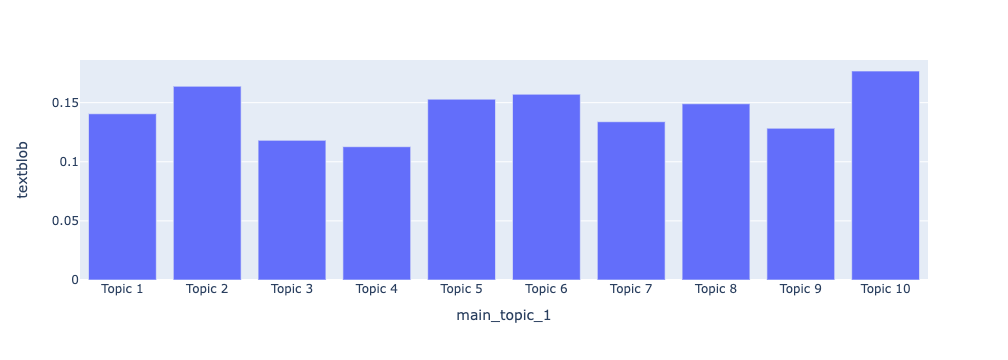

In [59]:
fig = px.bar(sa_topic, y= 'textblob')
fig.show()

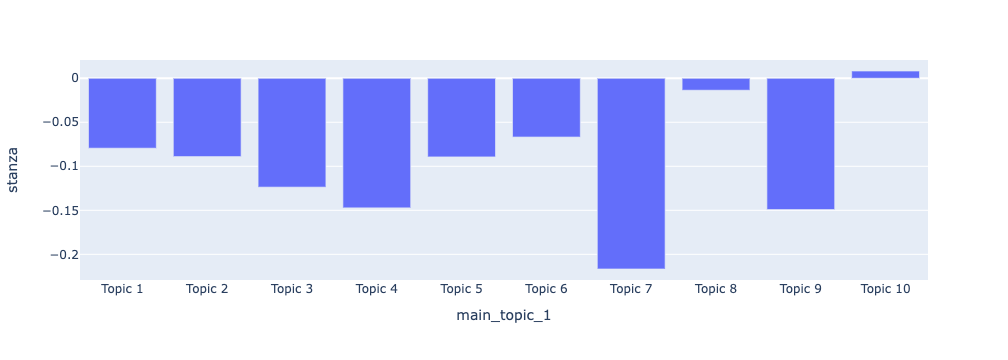

In [62]:
fig = px.bar(sa_topic, y= 'stanza')
fig.show()

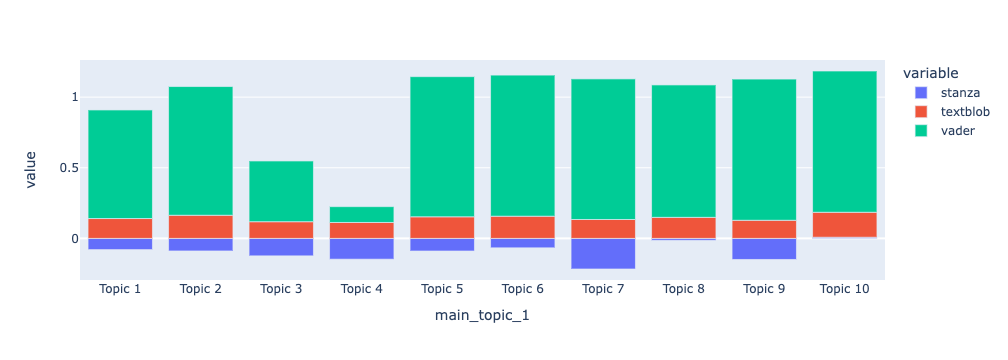

In [63]:
fig = px.bar(sa_topic, y= ['stanza', 'textblob', 'vader'])
fig.show()